In [1]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Załadowanie danych

In [2]:
train_x = pd.read_csv('https://raw.githubusercontent.com/mini-pw/2021L-WUM/main/Prace_domowe/Praca_domowa7/train.csv')
train_y = np.array([0]*len(train_x))
test = pd.read_csv('https://raw.githubusercontent.com/mini-pw/2021L-WUM/main/Prace_domowe/Praca_domowa7/test.csv')
test_x = test[test.columns[1:]]
test_y = test[test.columns[0]]
val = pd.read_csv('https://raw.githubusercontent.com/mini-pw/2021L-WUM/main/Prace_domowe/Praca_domowa7/val.csv')

# Model

In [3]:
# Helper functions to display a grid of plots
plotGrid_length = 0
plotGrid_height = 0
plotGrid_count = 0
def initPlotGrid(rowLength, totalPlots, showTicks = False):
    global plotGrid_length, plotGrid_count, plotGrid_height
    plotGrid_length = rowLength
    plotGrid_height = (totalPlots // rowLength) + 1 if totalPlots % rowLength > 0 else totalPlots // rowLength
    plotGrid_count = 0
    plotGrid_size = 10+2*rowLength
    
    plt.rcParams['figure.figsize'] = [plotGrid_size, plotGrid_size/plotGrid_length*plotGrid_height*0.8]
    if(not showTicks):
        plt.rcParams['axes.grid'] = False
        plt.rcParams['xtick.labelsize'] = False
        plt.rcParams['ytick.labelsize'] = False
        plt.rcParams['xtick.top'] = False
        plt.rcParams['xtick.bottom'] = False
        plt.rcParams['ytick.left'] = False
        plt.rcParams['ytick.right'] = False
    
def addToGrid():
    global plotGrid_length, plotGrid_count
    plt.subplot(plotGrid_height, plotGrid_length, plotGrid_count+1)
    plotGrid_count += 1
    
def finalizePlotGrid():
    plt.show()
    plt.style.use('default')

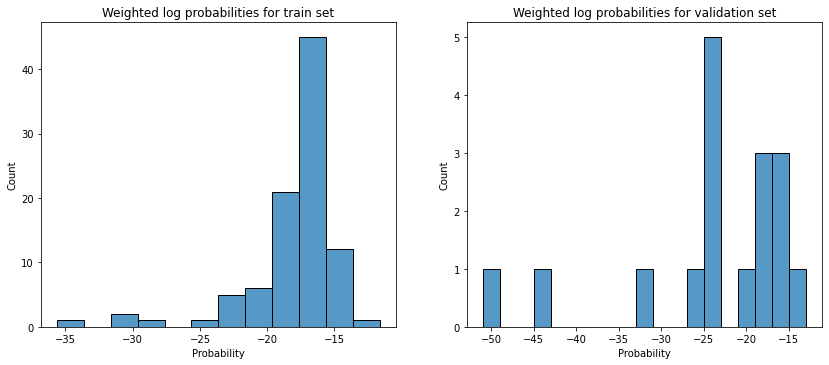

Minimum probability for train set: -35.632145622230794


In [4]:
gmm = GaussianMixture()
gmm.fit(train_x)

def analyzeProbability(title, data):
    score = gmm.score_samples(data)
    addToGrid()
    ax = sns.histplot(x=score,binwidth=2)
    ax.set_title('Weighted log probabilities for '+title)
    ax.set_xlabel('Probability');

initPlotGrid(2, 1, True)
analyzeProbability("train set",train_x)
analyzeProbability("validation set",val)
finalizePlotGrid()

print("Minimum probability for train set: "+str(np.min(gmm.score_samples(train_x))))

Wiemy że zbiór treningowy zawiera tylko punkty nie będące outlierami. Widać od razu że dla tego zbioru najmniejsza wartość prawdopodobieństwa wynosi około `-35.6`, więc potencjalną granicą byłaby wartość `-36`. 

Wykres dla zbioru walidacyjnego pokazuje jednak coś jeszcze - odstęp pomiędzy ostatnią wartością nie będącą outlierem a pierwszym outlierem jest dosyć spory. Można zatem zaproponować jeszcze dwie wartość granicy - `-40` i `-38`.

Bazując tylko i wyłącznie na tych dwóch zbiorach, wszystkie te granice są tak samo dobre. Dlatego w dalszej analizie wszystkie będą brane pod uwagę.

# Ewaluacja modeli

Bazując na zbiorze danych testowych, który zawiera etykiety punktów, możemy porównać jakość tych granic licząc odpowiednie metryki. W tym wypadku, jako że dla wszystkich wartości nie ma żadnej różnicy w zbiorze treningowym ani walidacyjnym, ich wykorzystanie nie da nam żadnych dodatkowych informajci.

In [5]:
results = pd.DataFrame({'F1 score': [], 'Precision': [], 'Recall': []})

def evaluateResult(treshold):
    pred_y = gmm.score_samples(test_x) < treshold
    
    f1_t = f1_score(test_y,pred_y)
    prec_t = precision_score(test_y,pred_y)
    rec_t = recall_score(test_y,pred_y)
    
    
    results.loc["Treshold "+str(treshold)] = [f1_t, prec_t, rec_t]
    
evaluateResult(-36)
evaluateResult(-38)
evaluateResult(-40)
results

,F1 score,Precision,Recall
Treshold -36,0.750000,1.0,0.6
Treshold -38,0.750000,1.0,0.6
Treshold -40,0.571429,1.0,0.4


Porównując metryki dla proponowanych granic, od razu widać że jakość modelu dla wartości `-40` jest zdecydowanie gorsza. Jednak w przypadku granic `-36` i `-38` nie widać najmniejszej różnicy w żadnej z metryk.

# Wizualizacja zbioru testowego

Jako dodatkowe porównanie modeli może nam służyć wizualizacja punktów na zbiorze testowym.

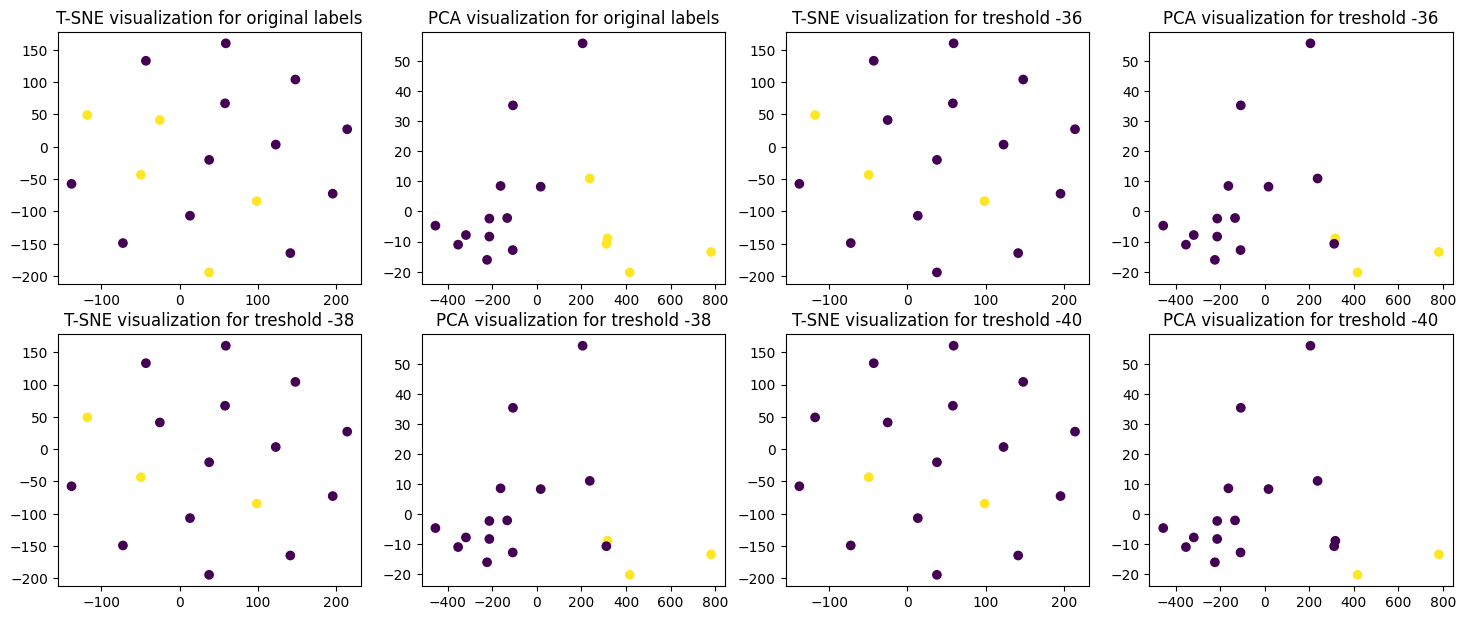

In [6]:
pca = PCA(n_components=2).fit_transform(test_x)
tsnedata = TSNE().fit_transform(test_x)


initPlotGrid(4, 8, True) 
# Visualization of original labels
addToGrid()
plt.scatter(tsnedata[:,0], tsnedata[:,1], c=test_y)
plt.title('T-SNE visualization for original labels')

addToGrid()
plt.scatter(pca[:,0], pca[:,1], c=test_y)
plt.title('PCA visualization for original labels')


def visualizeResult(treshold):
    pred_y = gmm.score_samples(test_x) < treshold
    
    addToGrid()
    plt.scatter(tsnedata[:,0], tsnedata[:,1], c=pred_y)
    plt.title('T-SNE visualization for treshold '+str(treshold))
    
    addToGrid()
    plt.scatter(pca[:,0], pca[:,1], c=pred_y)
    plt.title('PCA visualization for treshold '+str(treshold))

visualizeResult(-36)
visualizeResult(-38)
visualizeResult(-40)
finalizePlotGrid()

W tym wypadku wizualizacja T-SNE okazuje się zupełnie nieprzydatna. Wykresy PCA dają nam wytłumaczenie czemu wyniki dla granicy `-36` i `-38` są identyczne - zbiór testowy jest za mały, więc nie różnią się nawet jedną próbką. Sugerują one także że niższa wartość granicy mogłaby być bardziej efektywna w przypadku tego zbioru testowego, jednak patrząc na zbiór trenigowy, nie wiemy czy będzie tak w przypadku ogólnym.

Jako że, tak jak było to już wcześniej zauważone, zarówno w zbiorze treningowym jak i zbiorze walidacyjny nie ma żadnej różnicy pomiędzy wartościami `-36` i `-38`, nie jesteśmy w stanie porównać tych modeli. W tym wypadku najlepszym rozwiązaniem może okazać się wzięcie średniej z tej granicy jako modelu finalnego. Alternatywnie, można wybrać jedną z tych granic w zależności od konkretnego zastosowania i skutków FP i FN.